## Deep Quantile Regression - Loss function

The goal of this notebook is to have an intuitive idea of the **quantile loss function** used in deep quantile regression for estimating prediction intervals

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('INFO')

mpl.rcParams['figure.figsize'] = 20, 10

### Quantile Loss

[Reference post](https://medium.com/analytics-vidhya/prediction-intervals-in-forecasting-quantile-loss-function-18f72501586f)

##### Loss individual data point

$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$

* $\alpha$: the required quantile (a value between 0 and 1)
* $\xi_i = y_i - f(\mathbf{x}_i)$
* $f(\mathbf{x}_i)$ is the predicted (quantile)

##### Loss function

$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

In [2]:
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = f - y
    #e = y - f . NOTE: IMPORTANT!! Sometimes the error is computed in this form 
    return np.maximum(q * e, (q - 1) * e)

#### Intuitive interpretation


* *Overpredicting* f > y. The error will be positive and the first term will dominate 
* *Underpredicting* f < y. The error will be negative and the second term will dominate

Q is a penalization factor
 * q=0.5 under-prediction and over-prediction will be penalized by the same factor, the median is obtained
 * q=0.75 over-predictions will be penalized by a factor of 0.75, and under-predictions by a factor of 0.25


#### Loss function visualization

First, it is artificially generated error values in a interval of [-1,1] in order to understand how the quantile loss function behaves. 

In [11]:
quantile_loss_error = np.linspace(-1, 1, 1000)
quantile_loss_error_loss_10 = quantile_loss(0.1, 0, quantile_loss_error)
quantile_loss_error_loss_30 = quantile_loss(0.3, 0, quantile_loss_error)
quantile_loss_error_loss_50 = quantile_loss(0.5, 0, quantile_loss_error)
quantile_loss_error_loss_70 = quantile_loss(0.7, 0, quantile_loss_error)
quantile_loss_error_loss_90 = quantile_loss(0.9, 0, quantile_loss_error)

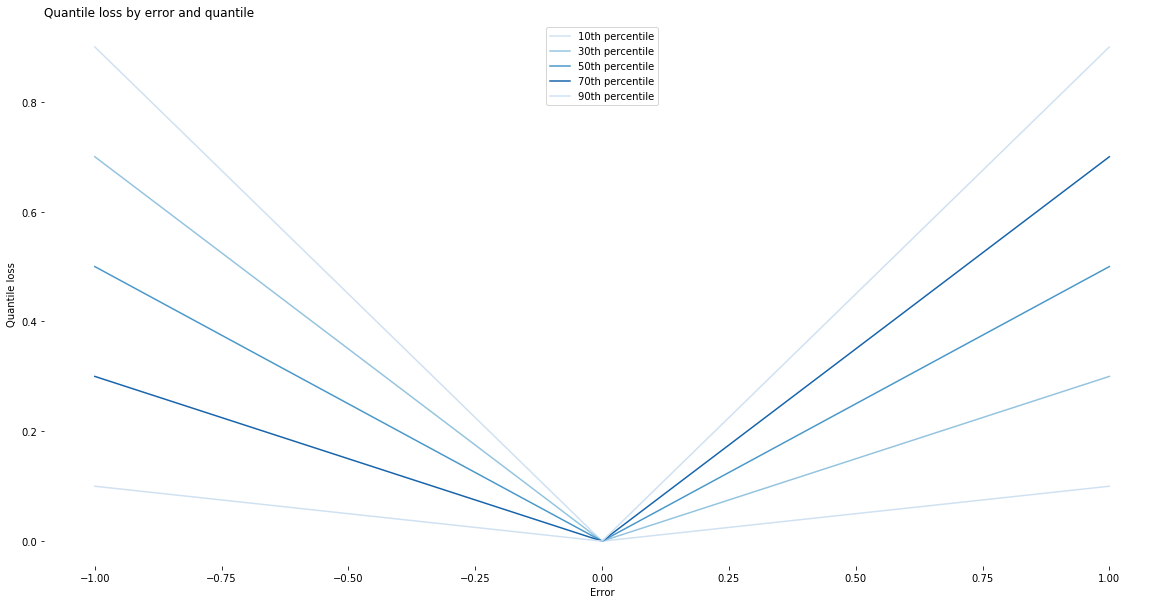

In [12]:
with sns.color_palette('Blues', 4):
    plt.plot(quantile_loss_error, quantile_loss_error_loss_10)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_30)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_50)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_70)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_90)
    plt.legend([str(int(q * 100)) + 'th percentile' for q in [0.1, 0.3, 0.5, 0.7, 0.9]])
    sns.despine(left=True, bottom=True)
    plt.xlabel('Error')
    plt.ylabel('Quantile loss')
    plt.title('Quantile loss by error and quantile', loc='left');

As we can see, the quantile loss value is dependent on the evaluated quantile. For the case of the quantile 50th the obtained loss is symmetric in both sides of [-1,0] and [0,1] so the errors comming from the predictions of both sides of the true value (overpredictting and underpredictting) are penalized equally. 

More positive errors are penalized more for higher quantiles and more negative errors are penalized more for lower quantiles. 

### Conclusions

The quantile loss function minimizes a weighted average error of predictions where the weights depends on the value of the quantile.

In the case of higher quantiles (e.g. q=0.90), the predictions over the true value in the Y axis for a specific data point X=x (predictions ordered vertical line at this X=x) are penalized more heavily so they are more important or have more relevance in the optimization process. The regression equation parameters will be adjusted to minimize more the error of the highest value predictions. 

Considering the formula for this specific q=0.90

Underprediction (error is negative):
    * q * e,
    * (q - 1) * e <--- We apply 0.90-1 * e.  A penalization factor of 0.10 over the error term
    

Overprediction (error is positive):
    * q * e
    * (q - 1) * e <---- We apply 0.90 * e. A penalization factor of 0.90 over the error term